In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("titanic_dataset.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


In [ ]:
df = df.drop(columns=["Cabin"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 112.6+ KB


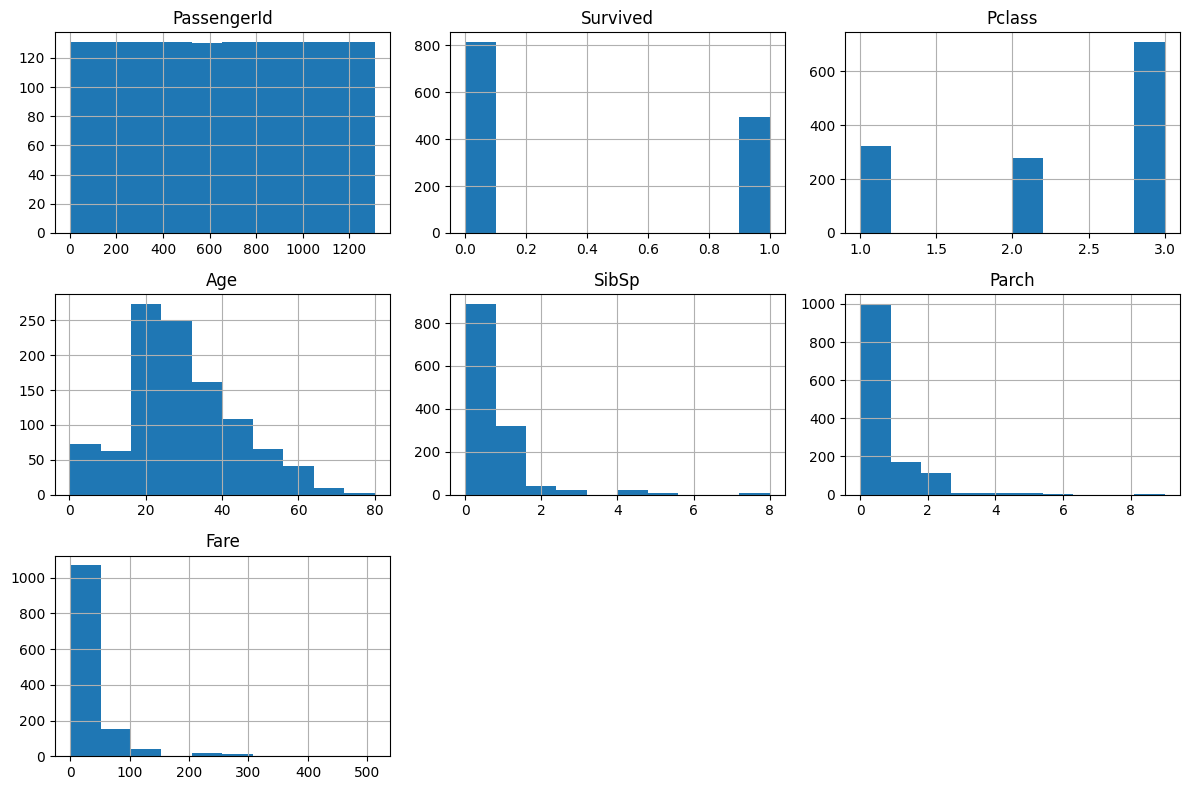

In [ ]:
# Histogram for each feature
df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()


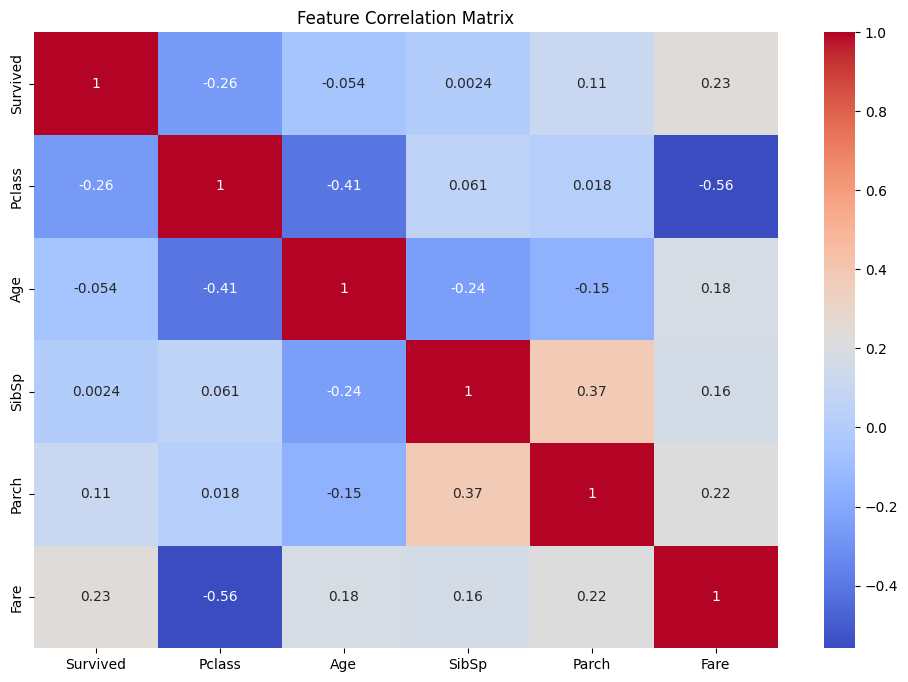

In [ ]:
df_num = df.select_dtypes(include="number").drop(columns="PassengerId")
corr_matrix = df_num.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [ ]:
x = df.drop(columns=["PassengerId","Survived"])
y = df["Survived"]

i guess data imbalance is not that bass

In [ ]:
print(df['Survived'].value_counts())

Survived
0    815
1    494
Name: count, dtype: int64


chec if stratify is neccary

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33, random_state=42, stratify= y)

In [ ]:
num_cols = df_num.columns
num_cols = num_cols.to_list()
cat_cols = [c for c in df.columns if c not in num_cols]
print(cat_cols, "and", num_cols)

['PassengerId', 'Name', 'Sex', 'Ticket', 'Embarked'] and ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


# Model 

In [ ]:
from sklearn.preprocessing import  OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

In [ ]:
pipe_pre = Pipeline([
    ("impute", imputer),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [ ]:
ct = ColumnTransformer([
    ("cat", pipe_pre , cat_cols)
])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()

In [ ]:
pipe_main = Pipeline([
    ("pre", pipe_pre),
    ("clf", model_rf)
])

In [ ]:
pipe_main.fit(x_train, y_train)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('impute', ...), ('encoder', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


In [ ]:
y_preb_base = pipe_main.predict(x_test)
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_preb_base)


0.8495370370370371

In [ ]:
from sklearn.metrics import average_precision_score , precision_recall_curve , f1_score

In [ ]:
print("base F1:", f1_score(y_test, y_preb_base))

base F1: 0.7840531561461794


In [ ]:
from sklearn.metrics import average_precision_score , precision_recall_curve , f1_score
proba_test = pipe_main.predict_proba(x_test)[:, 1]
ap = average_precision_score(y_test, proba_test)
print(f"Average Precision (PR-AUC): {ap:.3f} | Baseline ~ {y.mean():.3f}")


Average Precision (PR-AUC): 0.866 | Baseline ~ 0.377


In [ ]:
import numpy as np
prec, rec, thr = precision_recall_curve(y_test, proba_test)
f1s = (2*prec*rec)/(prec+rec+1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Best F1={f1s[best_idx]:.3f} at threshold={best_thr:.3f}")

Best F1=0.797 at threshold=0.420


In [ ]:
# --- 6) تصمیم‌گیری با آستانه‌ی انتخاب‌شده
y_pred = (proba_test >= best_thr).astype(int)
print("Final F1:", f1_score(y_test, y_pred))

Final F1: 0.7973856209150327


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8564814814814815

# why